#**Upravljanje multi-agentnim sustavima**

(verzija od 19.svi 2023.)

* koristimo Schurovu dekompoziciju za ortogonalni komplement od jezgre od $L$
* Plotamo vrijednost $||F_i(s)||$
* Koristi se samo sustav dimenzije $n$ (dimenzija Laplaceove matrice grafa) 
* Uvodimo 4 različite klase grafova na kojima ćemo testirati vrijedsnot $||F_i(s)||$


##**Raspisano**
Računamo vrijednost funkcije $F_i(s)$:
\begin{align*}
         F_i(s)  & = \frac{1}{is\alpha + \gamma}VV^T(L-\mu(s)I)^{-1}e_i \\
         & = \left[\: L = ZTZ^T \: \right]\\
         & = \frac{1}{is\alpha + \gamma}VV^TZ(T-\mu(s)I)^{-1}Z^*e_i  \\
         & = \left[ \: VV^TZ = VV^T[\:W \:\: V \:] = V \left[\:0 \: \: I\: \right]  \right] \\
         & = \frac{1}{is\alpha + \gamma}\left[\:0_{n×k} \:\: V \:\right](T-\mu(s)I)^{-1}Z^*e_i\\
         & = \left[\: Z^*e_i = [Z_0 Z_1]^T, \: \: Z_0 \in M_{k,1}, Z_1 \in M_{n-k,1}\: \right]\\
         & = \frac{1}{is\alpha + \gamma} V (T_{22} - \mu(s)I)^{-1} Z_1
\end{align*}

Za $L$ koristimo Schurovu dekompoziciju za $L= ZTZ^T$, $Z= [\: W\:\: V\:],$ $ \: W \in M_{n,k},$ $ \: V \in M_{n,n-k},$ gdje su V stupci od $Z$ koji pripadaju ne-nul elementima i dolazimo do oblika za $\Phi$ (jer vrijedi $L = L V V^T$):

$$\Phi(s) = \left(is \alpha + \gamma \right)\left(\frac{is\beta -s^2}{is \alpha + \gamma}I +L\right) = \\ =  (is \alpha + \gamma)\left(L - \mu(s)I\right),$$
gdje je $\mu(s) =\frac{is\beta -s^2}{is \alpha + \gamma} $.

Za vrijednost u $0$:
$$F_i(0) = \frac{1}{\gamma}V(V^TLV)^{-1}V^Te_i,$$ iskoristi se Schur za L i def za V pa se dobije
$$F_i(0) = \frac{1}{\gamma}VT_{22}^{-1}V^Te_i, $$
gdje je $$ T = 
\begin{bmatrix}
  T_{11} & T_{12}\\
  0 & T_{22}
  \end{bmatrix}.
$$ Pritom blok matrica $T_{11} \in M_{k,k}$ na dijagonali ima $0$, a $T_{22} \in M_{n-k,n-k}$ ima ne-nul svojstvene vrijednosti.




In [5]:
import networkx as nx

import numpy as np
from scipy.sparse import csgraph
import scipy.signal as signal
import scipy.linalg as la
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math
import time

###**`Laplace_inDegree`**
*   za graf G vraća Laplacian u željenoj formi.

In [6]:
def _Laplace_inDegree(G):
  A = nx.adjacency_matrix(G)
  A = np.transpose(A)
  D = np.diag(A @ np.ones(np.size(A,1)).transpose())
  return D-A;

##**`mu_`**
* input: $\alpha, \beta, \gamma$
*output: funkcija ovisna o parametru $s$:  $$\mu(s)=\frac{is\beta -s^2}{is \alpha + \gamma} $$

In [7]:
def mu_(alpha, beta, gamma):
    def mu(s):
        return (s*s-1j*s*beta)/(gamma + 1j*alpha*s);
    return mu;

###**`get_Fi`**
*   za graf $G$, parametre $\alpha, \beta, \gamma$, računa $Schurovu$ dekompoziciju inDegree Laplaceove matrice grafa, vraća ugnježdenu funkciju koja prima komponentu $i$ i dimenziju jezgre Laplaceove matrice grafa.

* pritom se kod računanja koristi `scipy.linalg.solve_triangular` koja poziva `LAPACK` rutinu za trokutasti linearni sustav jedndadžbi

Primjer poziva:

```
sys_f, Kernel_dim, ndim = get_Fi(G,alpha,beta,gamma)
Fi = sys_f(i)
print(Fi(5))
```




In [33]:
L = _Laplace_inDegree(G)
ndim = np.shape(L)[0];
T,Z,dim_Ker_L = la.schur(L, sort = lambda x: abs(x)<1e-12)
print(np.shape(T),dim_Ker_L, np.shape(Z[dim_Ker_L:,3]))
print(np.max(np.diag(T)))

AttributeError: 'tuple' object has no attribute 'edges'

In [ ]:
sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(G)
Fi = sys_f(2,1,1,1)
print(Fi(5))

In [32]:
def get_Fi_norm(G):
    L = _Laplace_inDegree(G)
    ndim = np.shape(L)[0];
    T,Z,dim_Ker_L = la.schur(L, sort = lambda x: abs(x)<1e-12)
    max_diagonal = np.max(np.abs(np.diag(T)))
    print("- - - - - Računam Schurovu dekompoziciju")
    V = Z[:,dim_Ker_L:]
    EYE = np.diag(np.ones(ndim - dim_Ker_L))
    
    def FF_(i,alpha,beta,gamma):
        alpha_2 = alpha*alpha
        gamma_2 = gamma*gamma
        M = mu_(alpha,beta,gamma)
        VTei = V.T.conj()[:,i-1]
        Z_Tei = Z.T.conj()[dim_Ker_L:,i-1]
        
        def Fi(s):
            if (s == 0):
                #A = T[dim_Ker_L:,dim_Ker_L:] #uzmemo T_22
                x = la.solve_triangular(T[dim_Ker_L:,dim_Ker_L:],VTei)  #solve_triangular poziva
                #LAPACK rutinu za trokutasti sustav
                nrm =la.norm(V @ x /gamma)
                F = nrm
            else:
                x = la.solve_triangular(T[dim_Ker_L:,dim_Ker_L:] - EYE*M(s),Z_Tei)
                F = la.norm(V @ x)/np.sqrt(s*s*alpha_2 + gamma_2)
            return F;
        return Fi;
    return FF_, dim_Ker_L, ndim, max_diagonal;

#**Poziv nekog grafa G:**

[Dokumentacija](https://networkx.org/documentation/stable/reference/generators.html#module-networkx.generators.directed) za generatore grafova.

`gn_graph(n[, kernel, create_using, seed])` - Returns the growing network (GN) digraph with n nodes.

`gnr_graph(n, p[, create_using, seed])` - Returns the growing network with redirection (GNR) digraph with n nodes and redirection probability p.

`gnc_graph(n[, create_using, seed])` - Returns the growing network with copying (GNC) digraph with n nodes.

`random_k_out_graph(n, k, alpha[, ...])` - Returns a random k-out graph with preferential attachment.

`scale_free_graph(n)` - Returns a scale-free directed graph.

In [20]:
import random
def scale_free_directed_graph(n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None):
    G = nx.DiGraph()
    G.add_node(0)

    nodes = list(G.nodes())
    cursor = 0
    random.seed(seed)

    while len(G) < n:
        r = random.random()

        if r < alpha:
            v = cursor
            cursor += 1
            w = random.choice(nodes)

        elif r < alpha + beta:
            v = random.choice(nodes)
            w = random.choice(nodes)

        else:
            v = random.choice(nodes)
            w = cursor
            cursor += 1

        if v != w and not G.has_edge(v, w):
            G.add_edge(v, w)

        nodes = list(G.nodes())

    return G

In [34]:
TTT = generate_graphs(4)
TTT[4][1]
for G in TTT:
    print(type(G[0]))

gnr_graph(4, 0.5)
<class 'networkx.classes.digraph.DiGraph'>
<class 'networkx.classes.digraph.DiGraph'>
<class 'networkx.classes.multidigraph.MultiDiGraph'>
<class 'networkx.classes.digraph.DiGraph'>
<class 'networkx.classes.digraph.DiGraph'>
<class 'networkx.classes.digraph.DiGraph'>
<class 'networkx.classes.digraph.DiGraph'>


In [22]:
def generate_graphs(n):
    A = nx.gnr_graph(n, 0.5)
    B = nx.gnc_graph(n)
    C = nx.random_k_out_graph(n, 4, 50.0, self_loops=False, seed=None)    
    D = scale_free_directed_graph(n)
    E = nx.gn_graph(n)
    F = nx.gn_graph(n, kernel=lambda x: x ** 1.5)
    G = nx.gn_graph(n, kernel=lambda x: math.exp(x*1.4))
        
    descriptionA = "gnr_graph(" + str(n) + ", 0.5)"
    descriptionB = "gnc_graph(" + str(n) + ")"
    descriptionC = "random_k_out_graph(" + str(n) + "4, 50.0, self_loops=False, seed=None)"
    descriptionD = "scale_free_directed_graph("+str(n)+")"
    descriptionE = "gn_graph(" + str(n) + ")"
    descriptionF = "gn_graph(" + str(n) + ", kernel=lambda x: x ** 1.5)"
    descriptionG = "gn_graph(" + str(n) + ", kernel=lambda x: math.exp(x*1.4))"
    
    return [(A,descriptionA),(B,descriptionB),(C,descriptionC),(D,descriptionD),(E,descriptionE),(F,descriptionF),(G,descriptionG)]

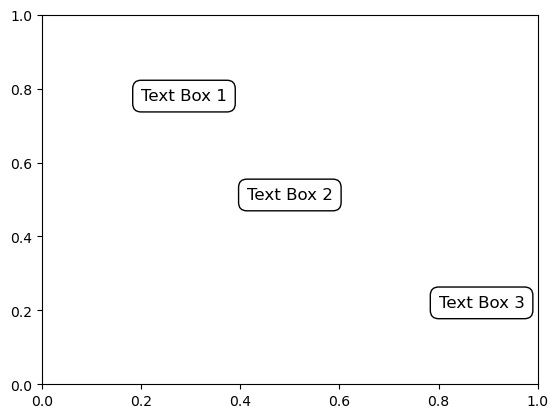

In [9]:
# Create a plot
plt.figure()

# Add text boxes
text_box1 = plt.text(0.2, 0.8, 'Text Box 1', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
text_box2 = plt.text(0.5, 0.5, 'Text Box 2', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
text_box3 = plt.text(0.8, 0.2, 'Text Box 3', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Customize the text boxes
text_box1.set_verticalalignment('top')
text_box2.set_horizontalalignment('center')
text_box3.set_verticalalignment('bottom')

# Show the plot
plt.show()

In [10]:
# CounterExamples_0.append((G,gamma,indexi,optimal_s, ranges, obj_values, args, poruka))
for i in CounterExamples_0[0]:
    print(type(i))
    try:
        print(len(i))
    except:
        continue

NameError: name 'CounterExamples_0' is not defined

In [11]:
G,gamma,s_opt, s_range, vals, arg = CounterExamples_3[0]
print(arg)
#print(np.size(s_range))
#print(len(vals))
sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(G)
Fi = sys_f(0,1,1,gamma)
plt.figure(figsize=(20,10))
plt.plot()
s_opt_index = np.where(s_range == s_opt)[0][0]
s_opt_obj = vals[s_opt_index]
plt.scatter(s_opt, s_opt_obj, color='red', label='s_opt')
ind = s_opt_index+20
plt.plot(s_range[:ind], vals[:ind], label = f"i={i}")

plot_norm_function(G,gamma,s_opt, s_range, vals, arg)

NameError: name 'CounterExamples_3' is not defined

In [12]:
def plot_norm_function(G,gamma,s_opt, s_range, vals, arg):
    i =0
    plt.figure(figsize=(20,10))
    #for obj in obj_values:
    print(np.size(s_range))
    print(len(vals))
    plt.plot()
    s_opt_index = np.where(s_range == s_opt)[0][0]
    print(s_opt_index)
    s_opt_obj = vals[s_opt_index]
    plt.scatter(s_opt, s_opt_obj, color='red', label='s_opt')
    ind = s_opt_index+20
    plt.plot(s_range[:ind], vals[:ind], label = f"i={i}")
    i+=1;

    plt.xlabel('s')
    plt.ylabel('Max singular value')
    plt.yscale('log')
    plt.legend()
    
    #text_box1 = plt.text(0.2, 0.8, r'$\gamma = {}$'.format(gamma), fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    # Customize the text boxes
    text_box1.set_verticalalignment('top')

    plt.show()
    #print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)

In [13]:
def plot_graph(G, norm_values):
    plt.figure(figsize=(20,15))
    pos = nx.spring_layout(Graph)

    nodes = nx.draw_networkx_nodes(Graph, pos, node_color=norm_values, cmap='coolwarm', node_size=70)
    edgclr = (224/255.0,229/255.0,255/255.0)
    nx.draw_networkx_edges(Graph, pos,edge_color=edgclr)

    #Odaberemo 10 vrhova s najvećom normom
    largest_indices = np.argsort(norm_values)[-10:]
    node_labels = {n: n for n in largest_indices}
    #node_labels = {n:norm_values[n] for n in Graph.nodes()}
    nx.draw_networkx_labels(Graph, pos, labels=node_labels, font_color='black', verticalalignment='bottom', horizontalalignment='left')
    #nx.draw(Graph,pos, node_color = node_colors, cmap = 'coolwarm', node_size=100)# labels = node_labels)

    # Odvojeni colorbar plot
    cbar = plt.colorbar(nodes, label='Norm', orientation='horizontal', shrink=0.5)
    cbar.ax.set_xlabel('Norm Values')
    plt.subplots_adjust(bottom=0.2)  

    plt.title('Graf D sa obojanim vrhovima po vrijednosti Norme')
    plt.savefig('graph.png')  # Save the plot as a PNG file
    plt.show()
    print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
    print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

## Naći max od $H_\infty$: (npr. pomoću Nelder-Mead)

Računanje $max_{\omega \in \mathbb{R}} \overline{\sigma}(\hat{F}(j\omega))$

Računamo normu od:

$F_i(s) = VV^T \Phi(s)^{-1}e_i$

$F_i(0) = \frac{1}{\gamma}V (V^TLV)^{-1}V^Te_i$

$||F_i(s)||^2_\infty = sup_s||F_i(s)||^2_2 = sup_s ||VV^T \Phi(s)^{-1}e_i||^2_2$

Ovdje koristimo funkciju koja vraća normu vektora $F_i(s)$ pa je funkcija cilja u optimizaciju norma tog vektora.

U varijablu L_sigma spremimo najveću svojstvenu vrijednost.

In [14]:
val = [la.norm(Fi(s)) for s in s_range]
maxi= max(val)
arg = val.index(maxi)
print("Max je val[",arg,"] = ",maxi)

NameError: name 's_range' is not defined

In [31]:
def obj_fun(s):
    return -Fi(s)

# Odaberi broj vrhova:
n = 20
#Odaberi broj generiranja grupe grafova
N = 5
CounterExamples_0 = [] # Nelder-Mead i argmax nisu jednaki - (G,s_opt) - sadrži graf G i točku koju vraća Nelder-Mead - NM je zapeo u lokalnom ekstremu
CounterExamples_1= [] # Nelder-Mead daje isto kao i argmax - a nije u nuli

alpha = 1
beta = 1
start_time = time.time()
# N puta generirat ćemo grupu od 7 grafova
for j in range(N):
    
    start_time_j = time.time()
    print("\n",j,"-ta grupa grafova.")
    
    GRAPHS = generate_graphs(n)
    
    #za svaki graf tražimo gdje se postiže max
    # u G se nalazi tupple: (Graf, opis grafa)
    for G in GRAPHS:
        start_time_Graph = time.time()
        sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(G[0])
        print("Najveća svojstvena vrijednost: ",L_sigma)
        x0 = 0.1
        left_end = 0
        right_end = L_sigma*10
        spacing0 = 0.001
        spacing1 = 0.1
        bounds = [(left_end,right_end)]
        
        # variramo parametar gamma
        for k in range(1,11):
            start_time_gamma = time.time()
            gamma = k/10
            now = time.time()
            
            obj_values = []
            norm_values = []
            optimal_s = []
            norm0_values = []
            ranges = []
            indexi = []
            args = []
            not_in_list = True
            
            for i in range(ndim):
                Fi = sys_f(i,alpha,beta,gamma)
                res = minimize(obj_fun, x0, bounds=bounds, method='Nelder-Mead')
                s_opt = res.x[0]
                norm = -res.fun # spremi vrijednost maximuma
                norm_values.append(norm) # iznosi normi iz Nelder-Meada
                
                if (s_opt == 0.0):
                    s_range = np.arange(left_end,right_end, spacing1)
                else:
                    s_range = np.arange(left_end,s_opt, spacing0)
                    s_range = np.concatenate((s_range, np.arange(s_opt,s_opt*5, spacing0 )))
                    #s_range = np.concatenate((s_range, np.arange(s_opt*5,right_end, spacing1 )))
                
                vals = [la.norm(Fi(s)) for s in s_range]
                maxi = max(vals)
                arg = vals.index(maxi)
                
                #Što sve trebam spremiti?
                #trebam spremiti
                ### Graf za kojeg tvrdnja ne vrijedi
                ### gamma
                ### indeks i na kojem se max of Fi ne postiže u 0
                ### s_opt različite od nula
                ### s_range na kojem se ispituje max
                ### arg u obj_val u kojem se postiže max
                ### norm_values
                ### poruka
                
                if (arg != 0) and not_in_list:
                    not_in_list = False
                    indexi.append(i)
                    ranges.append(s_range)
                    optimal_s.append(s_opt) # spremljena točka s za koju se postiže min
                    #norm0_values.append(la.norm(Fi(0))) # iznosi norme u nuli.
                    obj_values.append(vals) # spremljen graf of Fi duž domene s
                    args.append(arg)
                    poruka = "Nađen kontraprimjer. gamma = "+ gamma+"    (i, s_opt,s_range[arg], arg) ="+ i, s_opt , s_range[arg], arg
                    print("       ",poruka)  
                elif (s_opt != s_range[arg]) and not_in_list:
                    not_in_list = False
                    indexi.append(i)
                    ranges.append(s_range)
                    optimal_s.append(s_opt) # spremljena točka s za koju se postiže min
                    #norm0_values.append(la.norm(Fi(0))) # iznosi norme u nuli.
                    obj_values.append(vals) # spremljen graf of Fi duž domene s
                    args.append(arg)
                    poruka = "Nađen kontraprimjer. Nelder-Mead zapeo u lok. ekstremu. gamma = ", gamma,"    (i, s_opt,s_range[arg], arg) =", i, s_opt , s_range[arg], arg
                    print("       ",poruka)                   
                    
            if not not_in_list:
                CounterExamples_0.append((G,gamma,indexi,optimal_s, ranges, obj_values, args, poruka, norm_values))
            end_time_gamma = time.time()
            print("     Vrijeme za gamma =",gamma,": {:.4f} sec".format(end_time_gamma - start_time_gamma))
                          
        end_time_Graph = time.time()
        print("- - - - - Vrijeme izvršavanja za jedan graf: {:.4f} sec".format(end_time_Graph - start_time_Graph))
    
    end_time_j = time.time()
    print(" Vrijeme izvršavanja ",j,"-te iteracije: {:.4f} sec\n".format(end_time_j - start_time_j))
end_time = time.time()
print("Ukupno vrijeme izvršavanja: {:.4f} sec\n".format(end_time - start_time))


 0 -ta grupa grafova.
gnr_graph(20, 0.5)


NameError: name 'get_Fi_norm' is not defined

In [155]:
CounterExamples_1[0][0]

In [200]:
i = 0
for k in range(2,11):
    print(CounterExamples_1[i])
    graph, s_opt = CounterExamples_1[i]
    gamma = k/10  # Replace with the actual value of gamma
    graph_type = "nx.random_k_out_graph(n, 4, 50.0, self_loops=False, seed=None)"
    new_tuple = (graph, s_opt, gamma, graph_type)
    CounterExamples_1[i] = new_tuple
    print(CounterExamples_1[i])
    i = i+1
    
for k in range(4,11):
    print(CounterExamples_1[i])
    graph, s_opt = CounterExamples_1[i]
    gamma = k/10  # Replace with the actual value of gamma
    graph_type = "scale_free_directed_graph(n)"
    new_tuple = (graph, s_opt, gamma, graph_type)
    CounterExamples_1[i] = new_tuple
    print(CounterExamples_1[i])
    i = i+1

(<networkx.classes.multidigraph.MultiDiGraph object at 0x00000212A6A952D0>, 0.015078125000000166, 0.2, 'nx.random_k_out_graph(n, 4, 50.0, self_loops=False, seed=None)')


ValueError: too many values to unpack (expected 2)

In [210]:
s_range = np.arange(0,0.578, 0.1)
s_range = np.concatenate((s_range, np.arange(0.578,2, 0.1)))
#s_ran_1 = np.arange(0.578,2, 0.1)
print(s_range)

[0.    0.1   0.2   0.3   0.4   0.5   0.578 0.678 0.778 0.878 0.978 1.078
 1.178 1.278 1.378 1.478 1.578 1.678 1.778 1.878 1.978]


In [141]:
print(len(CounterExamples_1),len(CounterExamples_2))

16 0


In [191]:
alpha=1
beta=1

for t in range(1):
    gamma=CounterExamples_1[t][2]
    opt = CounterExamples_1[t][1]
    Graph = CounterExamples_1[t][0]
    start_time = time.time()
    sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(Graph)
    print("Trajanje Schurove dekompozicije:", time.time()-start_time)

    x0 = 0.1
    left_end = 0
    right_end = L_sigma*10
    spacing = 0.001
    bounds = [(left_end,right_end)]
    
    s_range_values = []
    obj_values = []
    norm_values = []
    norm0_values = []
    for i in range(ndim):
        now = time.time()
        Fi = sys_f(i,alpha,beta,gamma)
        res = minimize(obj_fun, x0, bounds=bounds, method='Nelder-Mead')
        #print(res)
        s_opt = res.x[0] # spremljena točka s za koju se postiže min
        norm = -res.fun # spremi vrijednost maximuma
        norm_values.append(norm) # iznosi normi iz Nelder-Meada
        
        s_range = np.arange(left_end,s_opt, spacing0)
        s_range = np.concatenate((s_range, np.arange(s_opt,s_opt*5, spacing0 )))
        s_range = np.concatenate((s_range, np.arange(s_opt*5,right_end, spacing1 )))
                

        norm_0 = la.norm(Fi(0)) # spremi vrijednost u nula
        norm0_values.append(norm_0) # iznosi norme u nuli.

        vals = [la.norm(Fi(s)) for s in s_range]
        maxi = max(vals)
        arg = vals.index(maxi)
        obj_values.append(vals) # spremljen graf of Fi duž domene s

        #
        # if s_opt != 0 then spremi graf i sve šta treba
        #   provjeri je li u obj_values max u istoj točki
        #
        if  (s_opt != arg):# or (opt != s_opt): #(opt != arg) or
            print(i, "      ",opt, s_opt, arg)

        #print("  Trajanje ",i,"-te iteracije:", time.time()-now)
    end_time = time.time()
    #print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

- - - - - Računam Schurovu dekompoziciju
Trajanje Schurove dekompozicije: 0.0030138492584228516
0        0.015078125000000166 0.015078125000000166 15


KeyboardInterrupt: 

In [193]:
vals = obj[:50]
maxi = max(vals)
arg = vals.index(maxi)
print(arg, maxi)

0 1.2250559472022895


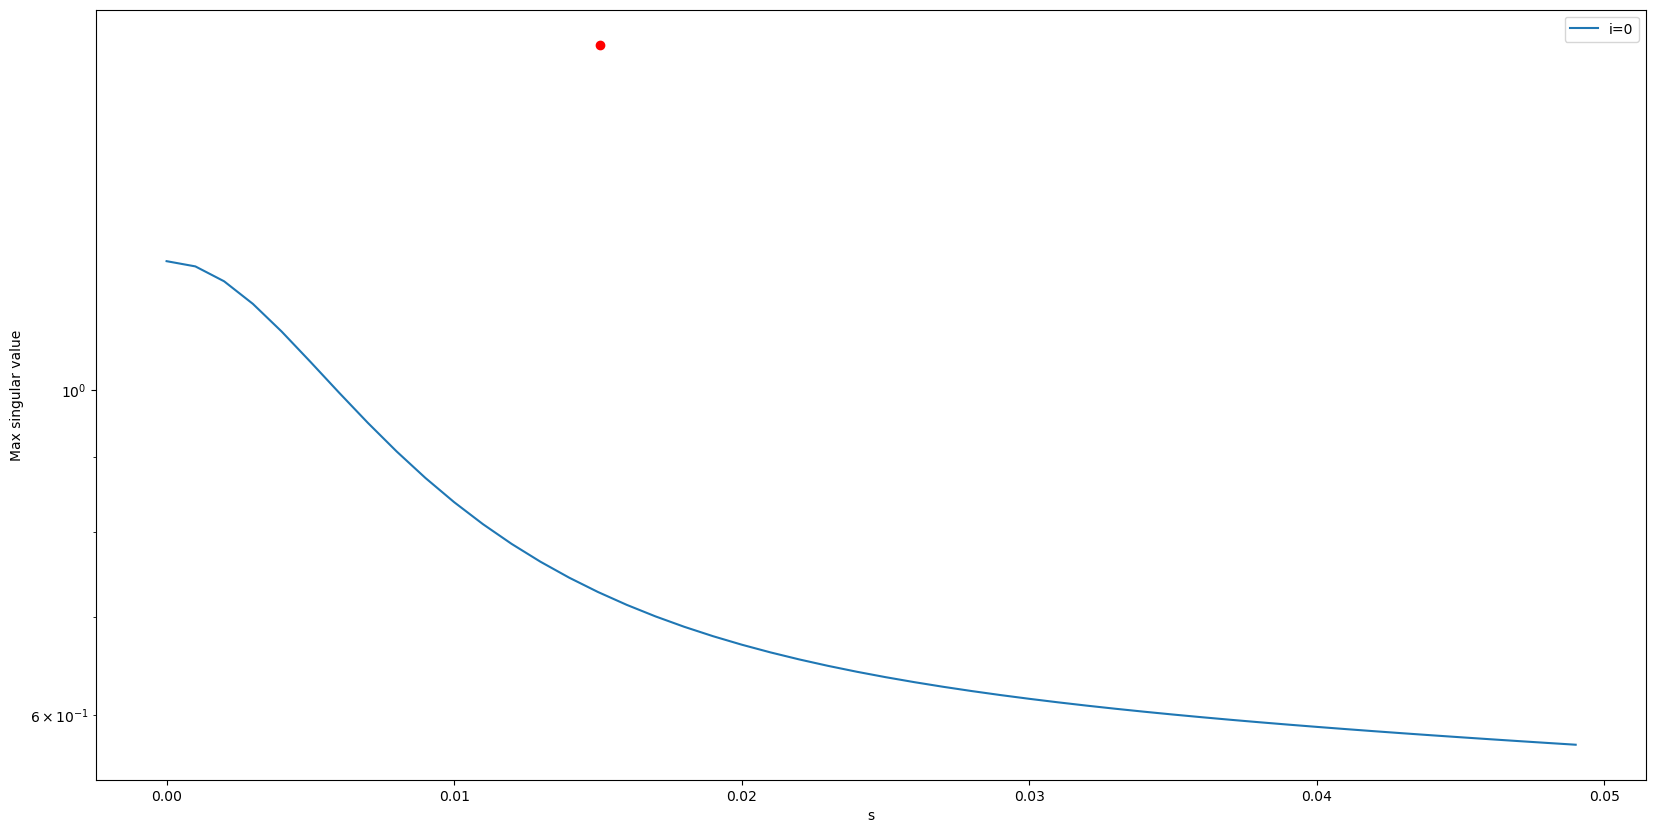

Dimenzija Laplaceove matrice:  60 
Dimenzija jezgre Laplaceove matrice:  1


In [195]:
i =0
plt.figure(figsize=(20,10))
start_time = time.time()
#for obj in obj_values:
#    plt.plot()
#    plt.plot(s_range, obj, label = f"i={i}")
#    i+=1;

plt.plot()
plt.plot(s_range[:50], obj[:50], label = f"i={i}")

end_time = time.time()
plt.xlabel('s')
plt.ylabel('Max singular value')
plt.yscale('log')
plt.legend()
#text_box1 = plt.text(0.2, 0.8, 'Text Box 1', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
#text_box2 = plt.text(0.5, 0.5, 'Text Box 2', fontsize=12, bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))
#text_box3 = plt.text(0.8, 0.2, 'Text Box 3', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.scatter(0.015078125000000166, norm_values[0], color='red', label='Optimal Point')
# Customize the text boxes
#text_box1.set_verticalalignment('top')
#text_box2.set_horizontalalignment('center')
#text_box3.set_verticalalignment('bottom')

plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ", Kernel_dim)

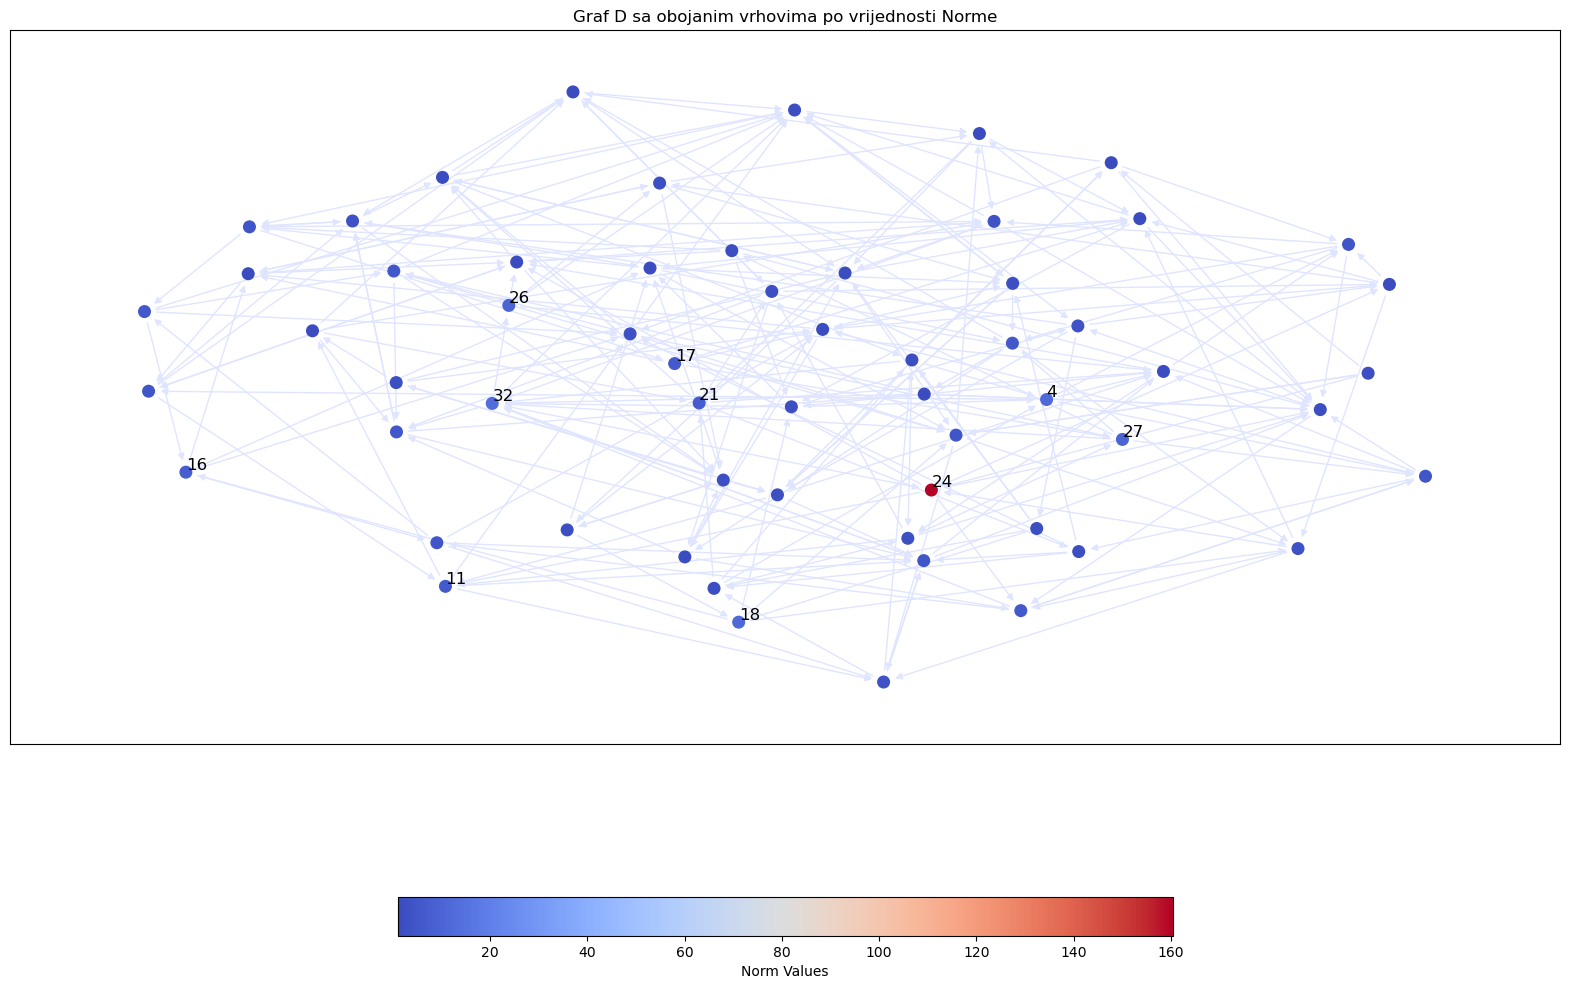

Dimenzija Laplaceove matrice:  60 
Dimenzija jezgre Laplaceove matrice:  1
Vrijeme izvršavanja:  0.6630420684814453 sec


In [188]:
# Plotanje grafa
plt.figure(figsize=(20,15))
pos = nx.spring_layout(Graph)

nodes = nx.draw_networkx_nodes(Graph, pos, node_color=norm_values, cmap='coolwarm', node_size=70)
edgclr = (224/255.0,229/255.0,255/255.0)
nx.draw_networkx_edges(Graph, pos,edge_color=edgclr)

#Odaberemo 10 vrhova s najvećom normom
largest_indices = np.argsort(norm_values)[-10:]
node_labels = {n: n for n in largest_indices}
#node_labels = {n:norm_values[n] for n in Graph.nodes()}
nx.draw_networkx_labels(Graph, pos, labels=node_labels, font_color='black', verticalalignment='bottom', horizontalalignment='left')
#nx.draw(Graph,pos, node_color = node_colors, cmap = 'coolwarm', node_size=100)# labels = node_labels)

# Odvojeni colorbar plot
cbar = plt.colorbar(nodes, label='Norm', orientation='horizontal', shrink=0.5)
cbar.ax.set_xlabel('Norm Values')
plt.subplots_adjust(bottom=0.2)  

plt.title('Graf D sa obojanim vrhovima po vrijednosti Norme')
plt.savefig('graph.png')  # Save the plot as a PNG file
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

Ovdje koristimo funkciju koja vraća normu vektora $||F_i(s)||$.

In [265]:
#def obj_fun(s):
 #   return -Fi(s)
Graph,gamma,s_opt0, s_range0, vals0, arg0 = CounterExamples_3[0]
sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(Graph)#,alpha,beta,gamma)
    
alpha=1
beta=1

x0 = 0.1
left_end = 0
right_end = s_opt0*5
spacing = 0.001
bounds = [(left_end,right_end)]
s_range = np.arange(left_end,right_end, spacing)

obj_values = []
norm_values = []
norm0_values = []
start_time = time.time()
print("Trajanje Schurove dekompozicije:", time.time()-start_time)
for i in range(ndim):
    now = time.time()
    Fi = sys_f(i,alpha,beta,gamma)
    res = minimize(Fi, x0, bounds=bounds, method='Nelder-Mead')
    #print(res)
    s_opt = res.x[0]
    norm = -res.fun
    norm_0 = Fi(0)
    #print(res.x, norm, "0",norm_0)
    #print(res.x, norm, "0",norm_0)
    obj_values.append([Fi(s) for s in s_range])
    norm_values.append(norm)
    norm0_values.append(norm_0)
    print("Trajanje ",i,"-te iteracije:", time.time()-now)
end_time = time.time()
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

- - - - - Računam Schurovu dekompoziciju
Trajanje Schurove dekompozicije: 0.0
Trajanje  0 -te iteracije: 0.018549442291259766
Trajanje  1 -te iteracije: 0.01681804656982422
Trajanje  2 -te iteracije: 0.0236051082611084
Trajanje  3 -te iteracije: 0.023098230361938477
Trajanje  4 -te iteracije: 0.016517162322998047
Trajanje  5 -te iteracije: 0.015531063079833984
Trajanje  6 -te iteracije: 0.01676177978515625
Trajanje  7 -te iteracije: 0.015084266662597656
Trajanje  8 -te iteracije: 0.01503896713256836
Trajanje  9 -te iteracije: 0.01636648178100586
Trajanje  10 -te iteracije: 0.01492929458618164
Trajanje  11 -te iteracije: 0.01467275619506836
Trajanje  12 -te iteracije: 0.018998384475708008
Trajanje  13 -te iteracije: 0.01754474639892578
Trajanje  14 -te iteracije: 0.01579427719116211
Trajanje  15 -te iteracije: 0.019998550415039062
Trajanje  16 -te iteracije: 0.014981508255004883
Trajanje  17 -te iteracije: 0.015964746475219727
Trajanje  18 -te iteracije: 0.014926910400390625
Trajanje  1

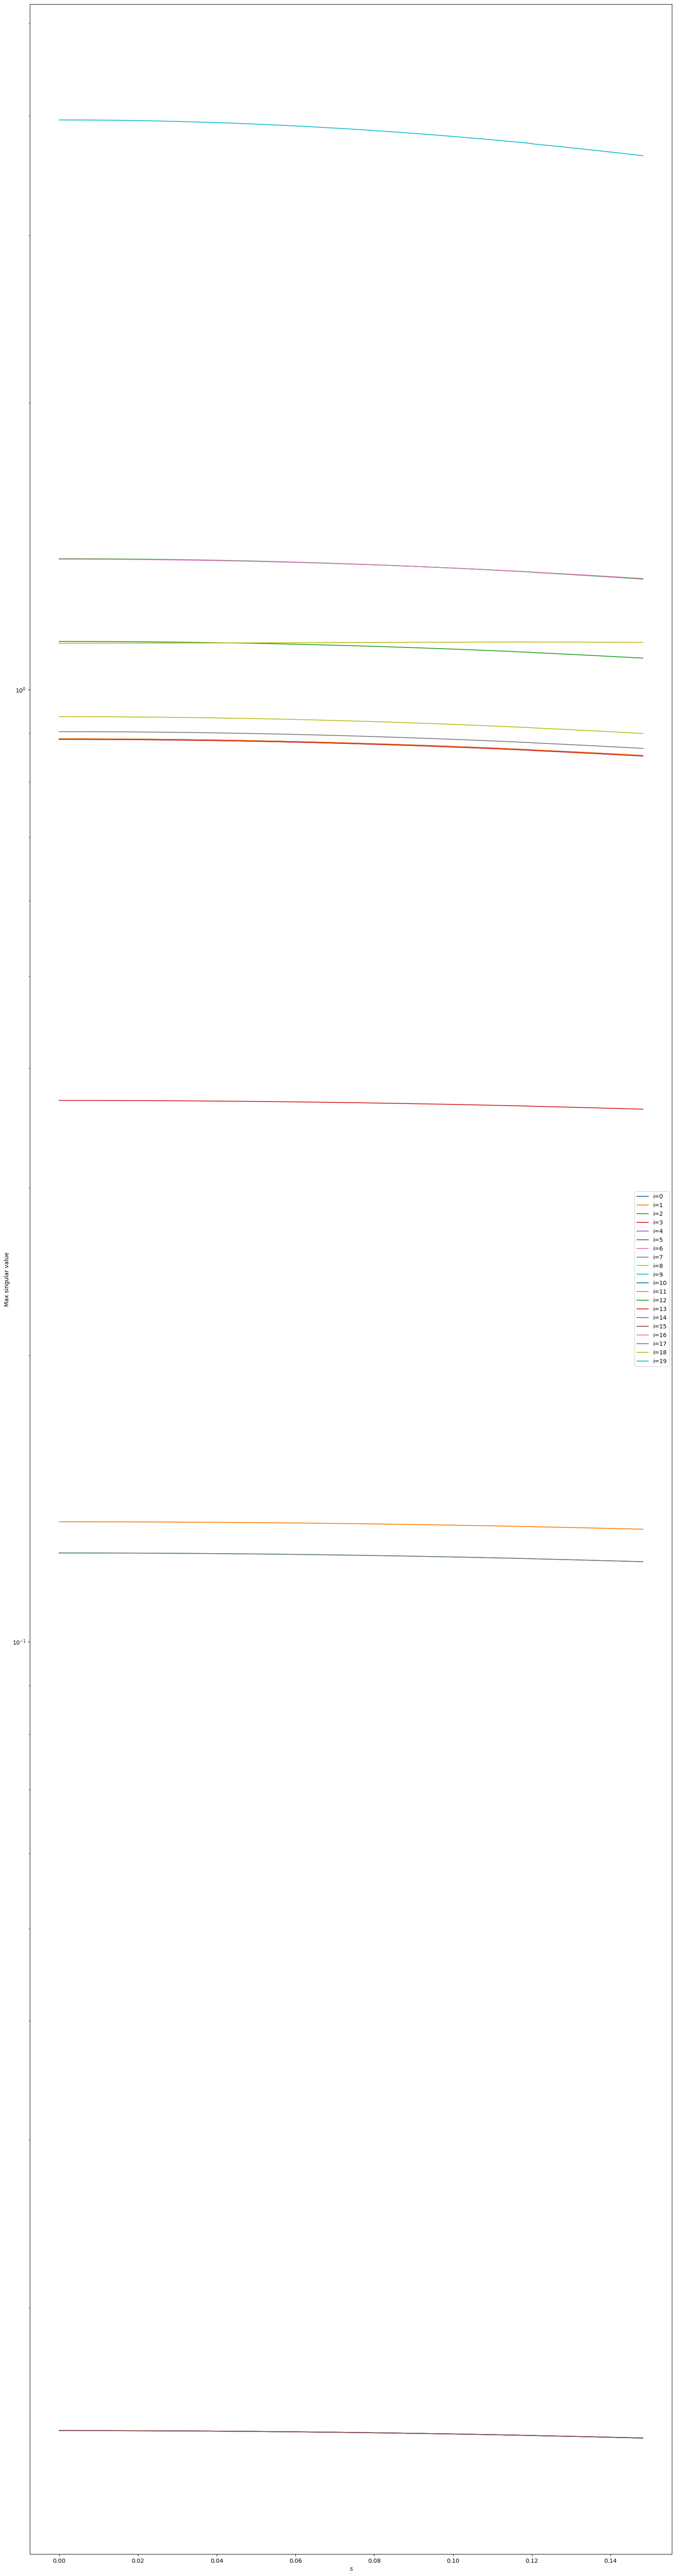

Dimenzija Laplaceove matrice:  20 
Dimenzija jezgre Laplaceove matrice:  11
Vrijeme izvršavanja:  0.025098323822021484 sec


In [280]:
i =0
plt.figure(figsize=(20,80))
start_time = time.time()
for obj in obj_values:
    plt.plot()
    plt.plot(s_range[:150], obj[:150], label = f"i={i}")
    #plt.annotate(f"i={i}", (s_range[-1], obj[-1]), xytext=(10, 0), textcoords='offset points', fontsize=10)
    i+=1;
    #break

end_time = time.time()
plt.xlabel('s')
plt.ylabel('Max singular value')
plt.yscale('log')
plt.legend()
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

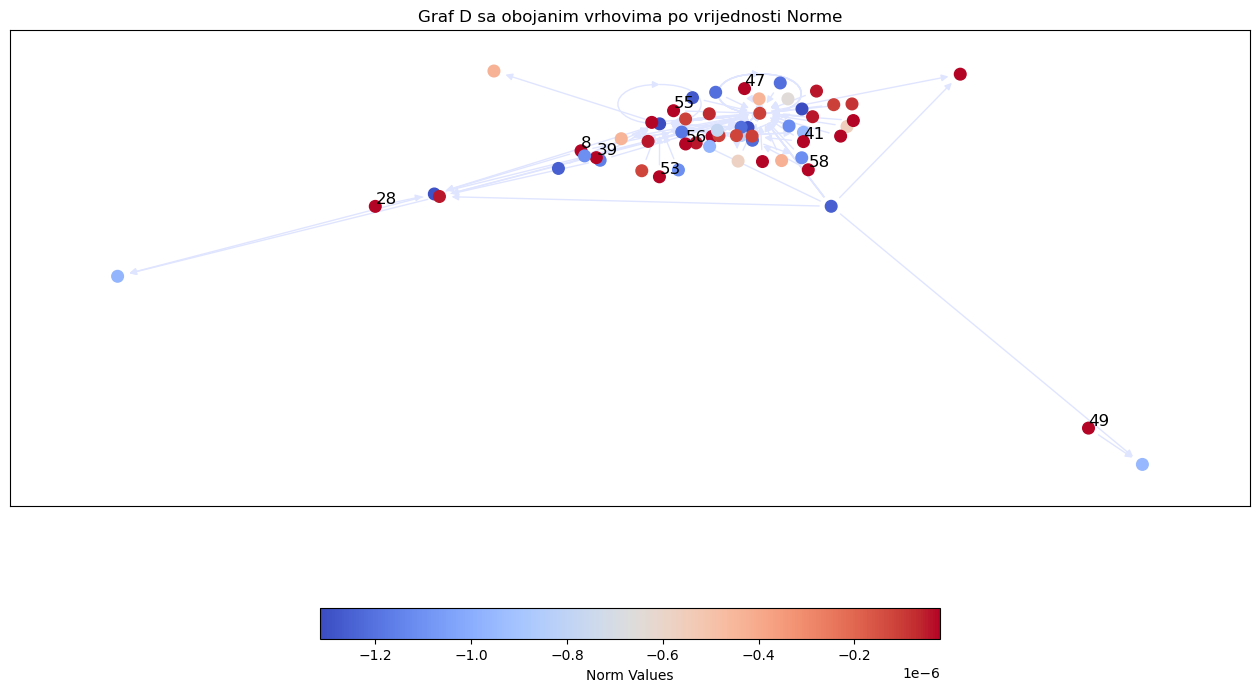

Dimenzija Laplaceove matrice:  60 
Dimenzija jezgre Laplaceove matrice:  42
Vrijeme izvršavanja:  0.08720755577087402 sec


In [118]:
# Plotanje grafa
plt.figure(figsize=(16,10))
pos = nx.spring_layout(Graph)
#node_labels = {n:norm_values[n] for n in Graph.nodes()}
#nx.draw(Graph,pos, node_color = node_colors, cmap = 'coolwarm', node_size=100)# labels = node_labels)
#plt.colorbar(label = 'Norm')
nodes = nx.draw_networkx_nodes(Graph, pos, node_color=norm_values, cmap='coolwarm', node_size=70)
edgclr = (224/255.0,229/255.0,255/255.0)
nx.draw_networkx_edges(Graph, pos,edge_color=edgclr)

#Odaberemo 10 vrhova s najvećom normom
largest_indices = np.argsort(norm_values)[-10:]
node_labels = {n: n for n in largest_indices}
nx.draw_networkx_labels(Graph, pos, labels=node_labels, font_color='black', verticalalignment='bottom', horizontalalignment='left')

# Odvojeni colorbar plot
cbar = plt.colorbar(nodes, label='Norm', orientation='horizontal', shrink=0.5)
cbar.ax.set_xlabel('Norm Values')
plt.subplots_adjust(bottom=0.2)  

plt.title('Graf D sa obojanim vrhovima po vrijednosti Norme')
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

In [75]:
node_labels1 = [{n: n for n in largest_indices},{n: '{:.5e}'.format(norm_values[n]) for n in largest_indices}]
node_labels1

[{41: 41,
  12: 12,
  22: 22,
  23: 23,
  54: 54,
  38: 38,
  49: 49,
  32: 32,
  26: 26,
  40: 40},
 {41: '1.04064e-01',
  12: '1.07749e-01',
  22: '1.19610e-01',
  23: '1.45841e-01',
  54: '1.53472e-01',
  38: '1.75937e-01',
  49: '1.78069e-01',
  32: '1.98875e-01',
  26: '2.06548e-01',
  40: '2.70531e-01'}]

In [ ]:
node_labels1[1][13]

'-9.16923e-04'

In [132]:
conda install -c conda-forge jupyterlab-lsp

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\fcack\miniconda3\envs\control

  added / updated specs:
    - jupyterlab-lsp


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.5.7   |       h56e8100_0         145 KB  conda-forge
    certifi-2023.5.7           |     pyhd8ed1ab_0         149 KB  conda-forge
    jupyter-lsp-2.1.0          |     pyhd8ed1ab_0          50 KB  conda-forge
    jupyterlab-lsp-3.10.2      |     pyhd8ed1ab_0         293 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         637 KB

The following NEW packages will be INSTALLED:

  jupyter-lsp        conda-forge/noarch::jupyter-lsp-2.1.0-pyhd8ed1ab_0 
  jupyterlab-lsp     conda-forge/noarch::jupyterlab-lsp-3.10.2-pyhd8ed1ab_0 

The



==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.3.1


